<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/Image_Inpaint_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Loading Dataset


In [3]:
!pip install datasets

In [4]:
from datasets import load_dataset
import pandas as pd

# Load the CelebA-HQ dataset
ds = load_dataset("saitsharipov/CelebA-HQ")

# Check if dataset loaded correctly
if ds is None:
    raise ValueError("Dataset not loaded correctly")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/224 [00:00<?, ?B/s]

(…)-00000-of-00003-30fbdf94a5d8e722.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

(…)-00001-of-00003-74b418aa7a721747.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

(…)-00002-of-00003-4f9459a488896f53.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/202599 [00:00<?, ? examples/s]

# Step 2: Exploratory Data Analysis (EDA)


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 202599
    })
})

First few items in the training set:
Item 0:
  image: <PIL.Image.Image image mode=RGB size=(178, 218)>

Item 1:
  image: <PIL.Image.Image image mode=RGB size=(178, 218)>

Item 2:
  image: <PIL.Image.Image image mode=RGB size=(178, 218)>

Item 3:
  image: <PIL.Image.Image image mode=RGB size=(178, 218)>

Item 4:
  image: <PIL.Image.Image image mode=RGB size=(178, 218)>


Column names:
['image']

DataFrame head:
                                               image
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...

Column data types:
image    object
dtype: object
Basic statistics of image properties:
        width  height  aspect_ratio
count  1000.0  1000.0  1.

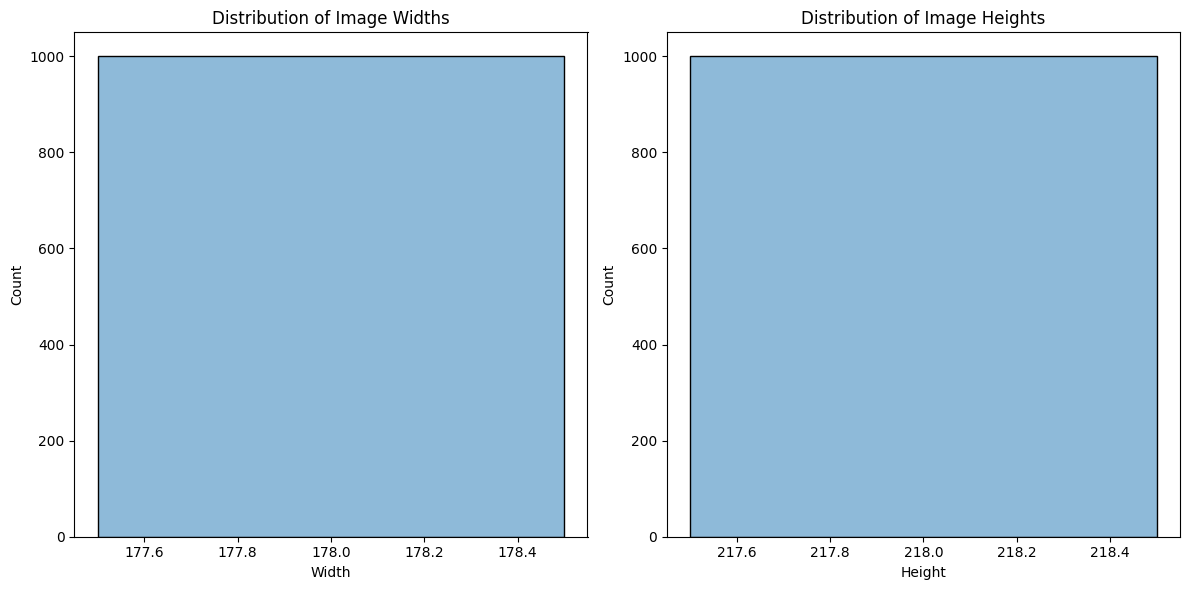

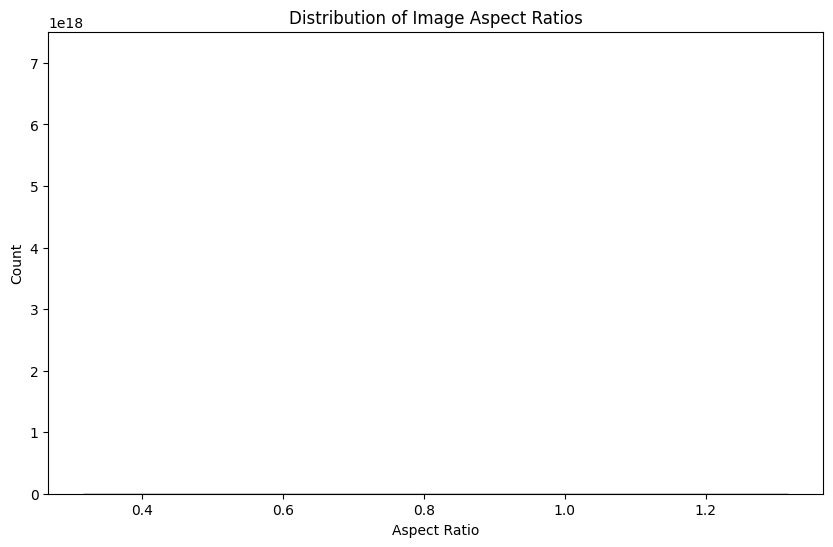

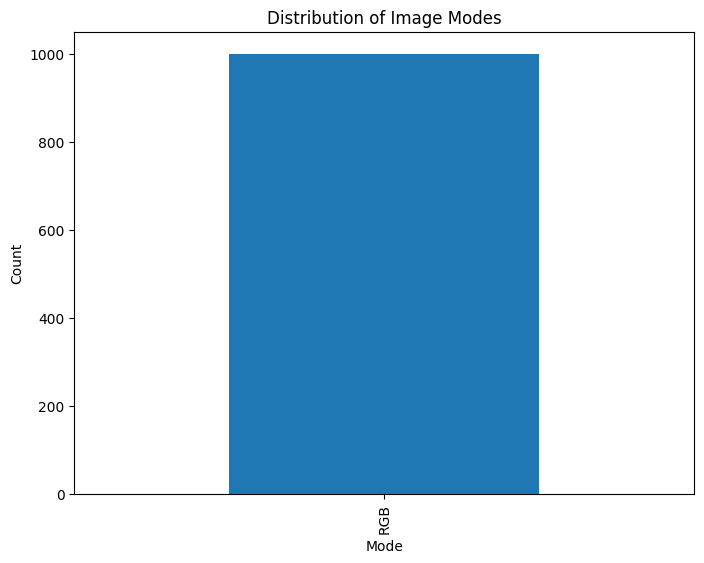

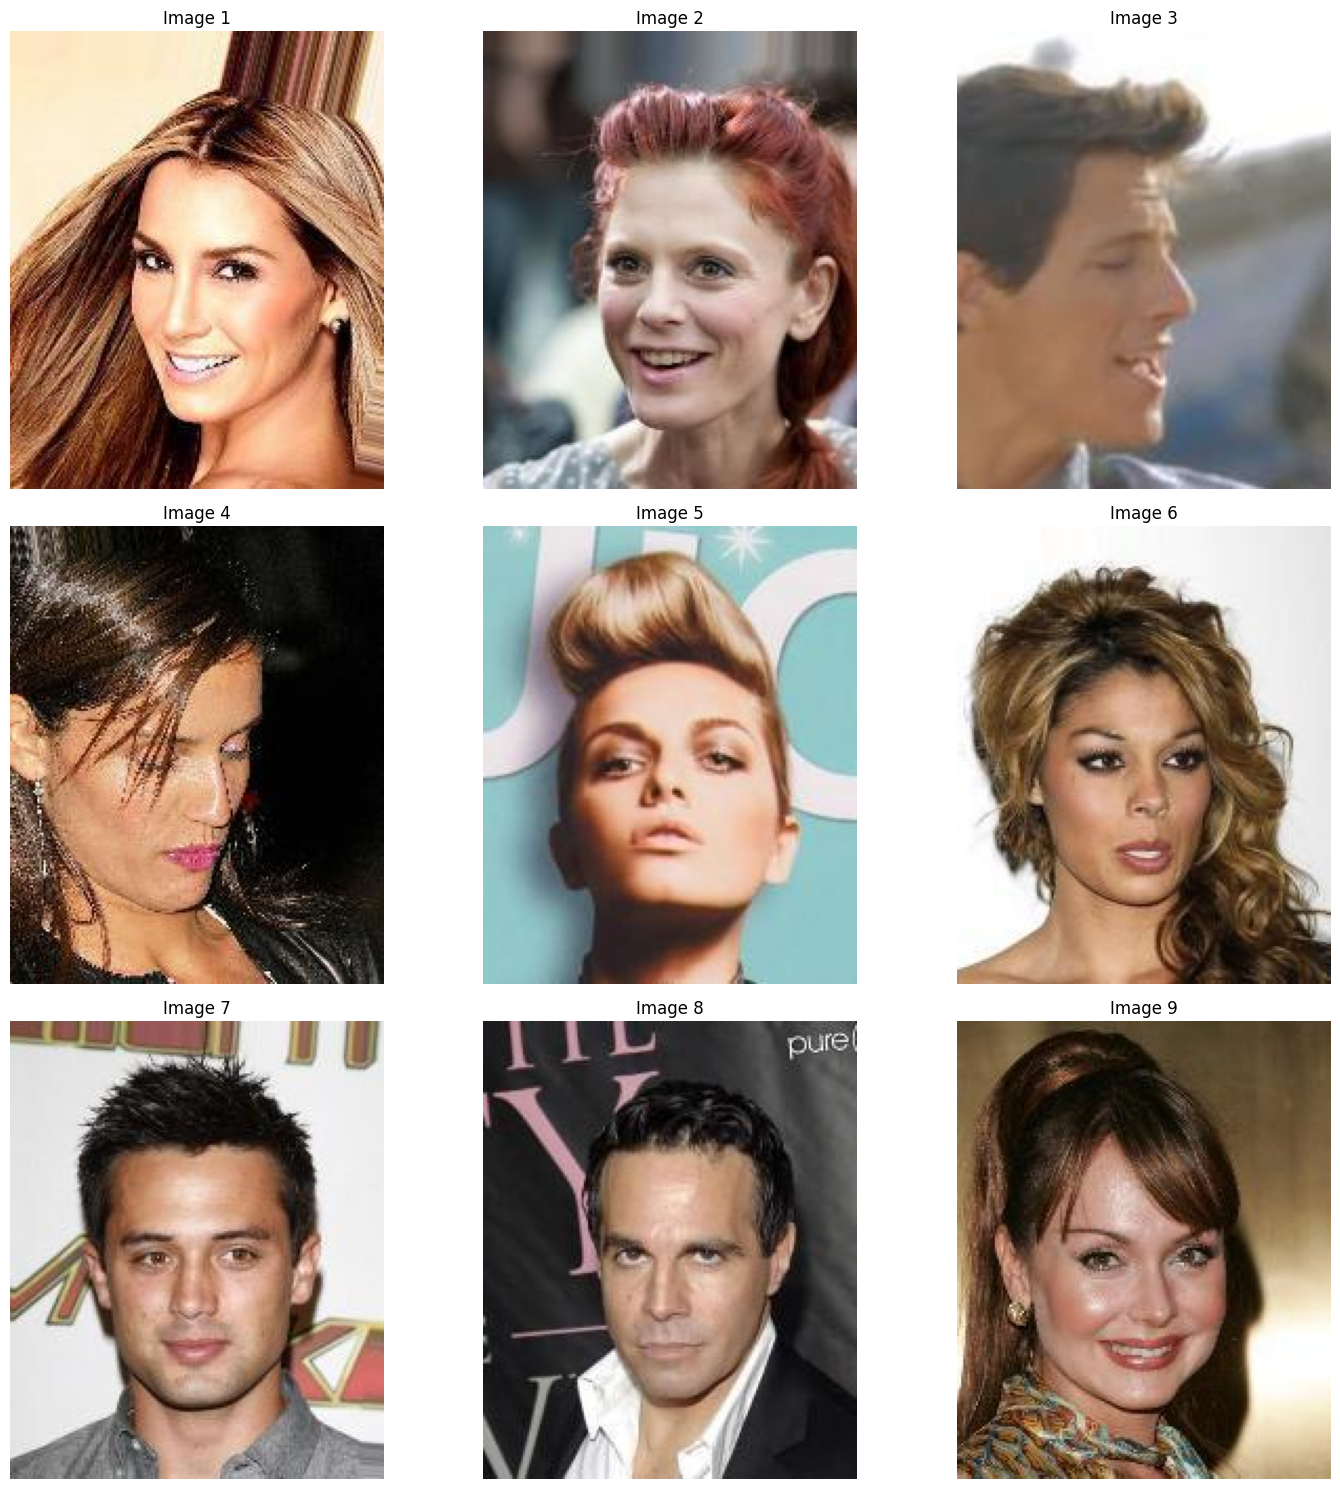

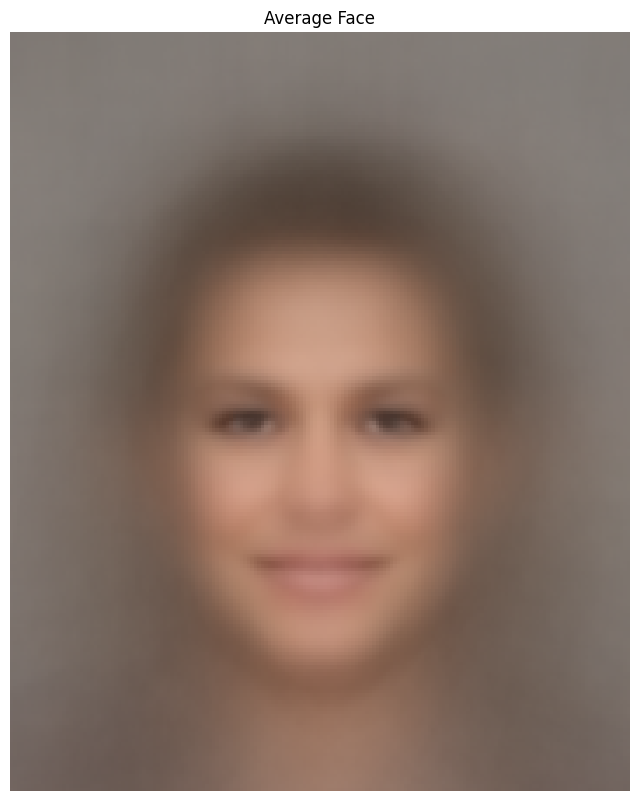

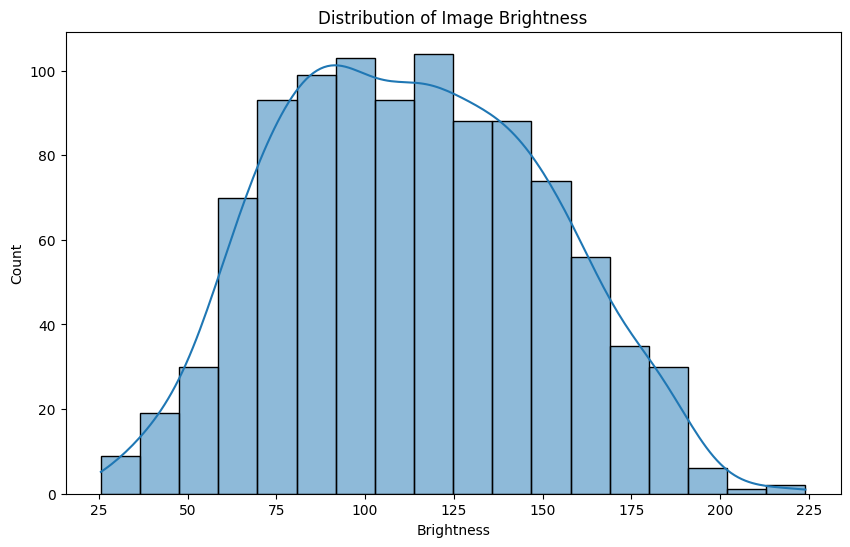

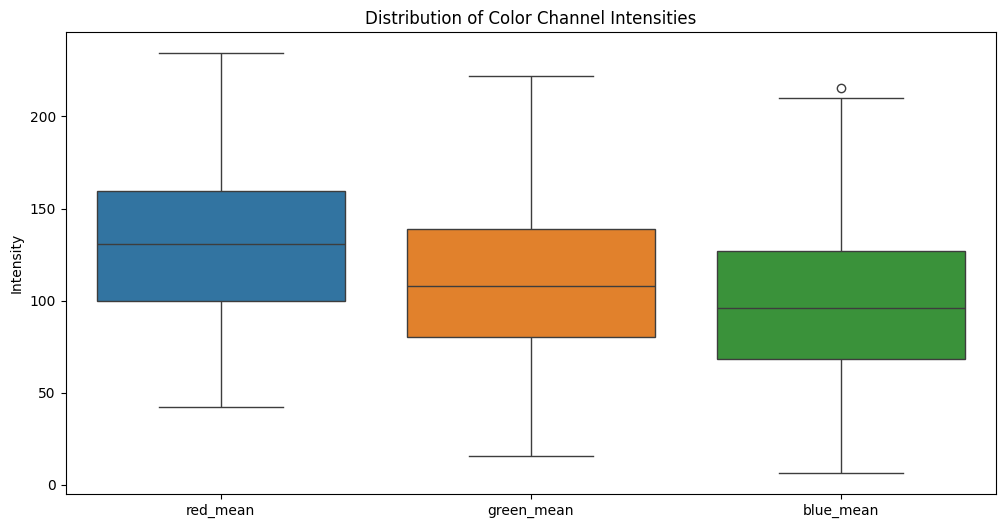

In [7]:
# Import necessary libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import tensorflow as tf
from tensorflow.keras import layers, models
import random

# Step 1: Load dataset
# Load the CelebA-HQ dataset
ds = load_dataset("saitsharipov/CelebA-HQ")

# Print basic information about the dataset
print("Dataset structure:")
print(ds)

# Inspect the first few items in the training set
print("\nFirst few items in the training set:")
for i, item in enumerate(ds['train'].select(range(5))):
    print(f"Item {i}:")
    for key, value in item.items():
        if key == 'image':
            print(f"  {key}: <PIL.Image.Image image mode={value.mode} size={value.size}>")
        else:
            print(f"  {key}: {value}")
    print()

# Get all column names (attributes)
column_names = list(ds['train'].features.keys())
print("\nColumn names:")
print(column_names)

# Convert a small subset of the dataset to a pandas DataFrame for easier inspection
df = pd.DataFrame(ds['train'].select(range(100)))
print("\nDataFrame head:")
print(df.head())

# Print data types of columns
print("\nColumn data types:")
print(df.dtypes)


# Step 2: EDA
# Function to extract image properties
def get_image_properties(image):
    return {
        'width': image.width,
        'height': image.height,
        'aspect_ratio': image.width / image.height,
        'mode': image.mode
    }

# Define number of samples
num_samples = 1000

# Extract properties for a subset of images
image_properties = [get_image_properties(item['image']) for item in ds['train'].select(range(num_samples))]
df_properties = pd.DataFrame(image_properties)

# 1. Basic statistics of image properties
print("Basic statistics of image properties:")
print(df_properties.describe())

# 2. Distribution of image dimensions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_properties['width'], kde=True)
plt.title('Distribution of Image Widths')
plt.xlabel('Width')

plt.subplot(1, 2, 2)
sns.histplot(df_properties['height'], kde=True)
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.tight_layout()
plt.show()

# 3. Distribution of aspect ratios
plt.figure(figsize=(10, 6))
sns.histplot(df_properties['aspect_ratio'], kde=True)
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.show()

# 4. Image modes
mode_counts = df_properties['mode'].value_counts()
plt.figure(figsize=(8, 6))
mode_counts.plot(kind='bar')
plt.title('Distribution of Image Modes')
plt.xlabel('Mode')
plt.ylabel('Count')
plt.show()

# 5. Sample images visualization
def plot_sample_images(dataset, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        image = dataset['train'][i]['image']
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Image {i+1}")
    plt.tight_layout()
    plt.show()

plot_sample_images(ds)

# 6. Average image
def compute_average_image(dataset, num_samples=1000):
    sample_images = dataset['train'].select(range(num_samples))
    avg_image = np.zeros((218, 178, 3), dtype=np.float32)

    for item in sample_images:
        img_array = np.array(item['image'], dtype=np.float32)
        avg_image += img_array

    avg_image /= num_samples
    return avg_image.astype(np.uint8)

avg_image = compute_average_image(ds, num_samples=num_samples)
plt.figure(figsize=(8, 10))
plt.imshow(avg_image)
plt.title('Average Face')
plt.axis('off')
plt.show()

# 7. Image brightness distribution
def compute_brightness(image):
    return np.mean(image)

brightness_values = [compute_brightness(item['image']) for item in ds['train'].select(range(num_samples))]

plt.figure(figsize=(10, 6))
sns.histplot(brightness_values, kde=True)
plt.title('Distribution of Image Brightness')
plt.xlabel('Brightness')
plt.show()

# 8. Color channel analysis
def analyze_color_channels(image):
    r, g, b = image.split()
    return {
        'red_mean': np.mean(r),
        'green_mean': np.mean(g),
        'blue_mean': np.mean(b)
    }

color_data = [analyze_color_channels(item['image']) for item in ds['train'].select(range(num_samples))]
df_colors = pd.DataFrame(color_data)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_colors)
plt.title('Distribution of Color Channel Intensities')
plt.ylabel('Intensity')
plt.show()


# Step 3: Preprocess dataset
class CelebAHQDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image']

        if self.transform:
            image = self.transform(image)

        return image

# Define image size and preprocessing steps
IMG_SIZE = 256
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Create the full dataset
full_dataset = CelebAHQDataset(ds['train'], transform=preprocess)

# Set random seed for reproducibility
torch.manual_seed(42)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


In [ ]:

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# Step 4: Create and measure models
# Define input shape
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 1. CNN Model
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return model

# 2. Simple RNN Model
def create_rnn_model():
    model = models.Sequential([
        layers.Reshape((IMG_SIZE * IMG_SIZE, 3), input_shape=INPUT_SHAPE),
        layers.SimpleRNN(256, return_sequences=True),
        layers.SimpleRNN(128, return_sequences=True),
        layers.Dense(3, activation='sigmoid'),
        layers.Reshape((IMG_SIZE, IMG_SIZE, 3))
    ])
    return model

# 3. LSTM Model
def create_lstm_model():
    model = models.Sequential([
        layers.Reshape((IMG_SIZE * IMG_SIZE, 3), input_shape=INPUT_SHAPE),
        layers.LSTM(256, return_sequences=True),
        layers.LSTM(128, return_sequences=True),
        layers.Dense(3, activation='sigmoid'),
        layers.Reshape((IMG_SIZE, IMG_SIZE, 3))
    ])
    return model

# 4. XLSTM Model
class XLSTMCell(layers.Layer):
    def __init__(self, units):
        super(XLSTMCell, self).__init__()
        self.units = units
        self.lstm_cell = layers.LSTMCell(units)

    def call(self, inputs, states):
        output, states = self.lstm_cell(inputs, states)
        return output, states

def create_xlstm_model():
    inputs = layers.Input(shape=INPUT_SHAPE)
    reshaped = layers.Reshape((IMG_SIZE * IMG_SIZE, 3))(inputs)
    xlstm = layers.RNN(XLSTMCell(256), return_sequences=True)(reshaped)
    xlstm = layers.RNN(XLSTMCell(128), return_sequences=True)(xlstm)
    outputs = layers.TimeDistributed(layers.Dense(3, activation='sigmoid'))(xlstm)
    outputs = layers.Reshape((IMG_SIZE, IMG_SIZE, 3))(outputs)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Training function (dummy for now, adjust as necessary)
def train_model(model, train_data, val_data, epochs=10):
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    model.fit(train_data, validation_data=val_data, epochs=epochs)
    return model.history

# Model comparison
model_names = []
histories = []

models = [
    ("CNN", create_cnn_model()),
    ("RNN", create_rnn_model()),
    ("LSTM", create_lstm_model()),
    ("XLSTM", create_xlstm_model())
]

for name, model in models:
    try:
        print(f"Training {name} model...")
        history = train_model(model, train_loader, val_loader, epochs=10)
        histories.append(history)
        model_names.append(name)
    except Exception as e:
        print(f"Error training {name} model: {e}")
